In [1]:
%matplotlib inline


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import splitfolders
import os.path

In [3]:

#test train data split 

splitfolders.ratio("./data/flowers/", output="output", seed=1337, ratio=(.8, .2), group_prefix=None)


Copying files: 4317 files [00:08, 483.69 files/s]


In [4]:
#Define Transforms
transform = transforms.Compose(
    [transforms.Resize((150,150)),transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#Hyper Parameters
batch_size = 4
learning_rate = 0.001
traindataset = datasets.ImageFolder('./output/train', transform=transform)
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size,
                                          shuffle=True)

testdataset = datasets.ImageFolder('./output/val', transform=transform)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size,
                                          shuffle=True)
classes = ('daisy','dandelion','rose','sunflower','tulip')



In [5]:
len(traindataset)

3452

In [6]:
len(testdataset)

865

In [7]:
print(traindataset.class_to_idx)

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


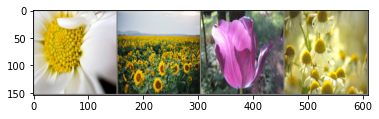

daisy sunflower tulip daisy


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 34 * 34, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)import matplotlib.pyplot as plt

Epoch [1/2], Step [100/863], Loss: 0.8527
Epoch [1/2], Step [200/863], Loss: 1.4881
Epoch [1/2], Step [300/863], Loss: 2.0720
Epoch [1/2], Step [400/863], Loss: 1.4074
Epoch [1/2], Step [500/863], Loss: 2.3987
Epoch [1/2], Step [600/863], Loss: 0.8642
Epoch [1/2], Step [700/863], Loss: 1.7752
Epoch [1/2], Step [800/863], Loss: 1.6486
Epoch [2/2], Step [100/863], Loss: 1.2208
Epoch [2/2], Step [200/863], Loss: 1.0629
Epoch [2/2], Step [300/863], Loss: 0.6270
Epoch [2/2], Step [400/863], Loss: 0.6663
Epoch [2/2], Step [500/863], Loss: 0.8056
Epoch [2/2], Step [600/863], Loss: 0.6664
Epoch [2/2], Step [700/863], Loss: 0.9832
Epoch [2/2], Step [800/863], Loss: 2.0714


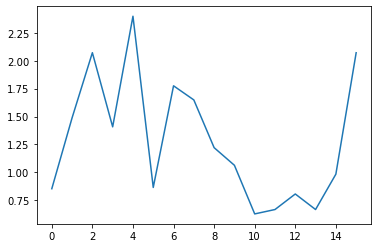

Finished Training


In [35]:
import matplotlib.pyplot as plt
loss_list = []
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
       
        # print statistics
        if (i+1) % 100 == 0:
            running_loss = loss.item()
            print (f'Epoch [{epoch+1}/{2}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss:.4f}')
            loss_list.append(running_loss)
            running_loss=0.0
plt.plot(loss_list)
plt.show()      
print('Finished Training')

In [12]:
PATH = './flowers_net.pth'
torch.save(net.state_dict(), PATH)

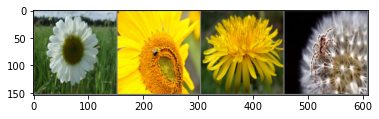

GroundTruth:  daisy sunflower dandelion dandelion


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [14]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [15]:
outputs = net(images)

In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  dandelion dandelion dandelion daisy


In [19]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testdataset)} test images: {100 * correct // total} %')

Accuracy of the network on the 865 test images: 49 %


In [20]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: daisy is 37.3 %
Accuracy for class: dandelion is 85.3 %
Accuracy for class: rose  is 32.5 %
Accuracy for class: sunflower is 27.2 %
Accuracy for class: tulip is 51.3 %
